## 多项式回归

In [1]:
import torch
import torch.nn as nn
import math
import lmy
import numpy as np



/Users/zane/miniforge3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


![image-20220322195534012](过拟合与欠拟合.assets/image-20220322195534012.png)

In [2]:

max_degreen = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degreen)
true_w[:4] = [5, 1.2, -3.4, 5.6]

In [4]:
features = np.random.normal(size=(n_test + n_train, 1))
np.random.shuffle(features)

In [5]:
poly_features = np.power(features, np.arange(max_degreen).reshape(1, -1))  #逐元素计算次数
for i in range(max_degreen):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
labels = np.dot(poly_features, true_w)  # y
labels += np.random.normal(scale=.1, size=labels.shape)

In [ ]:
labels

In [7]:
def net_accuracy(net, data_iter, loss):
    """评估模型准确率"""
    metric = lmy.Accumulator(2)
    for X, y in data_iter:
        y_hat = net(X)
        y = y.reshape(y_hat.shape)
        l = loss(y_hat, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

若设定loss=torch.nn.MSELoss(reduction='mean'),最终输出值是(target-input)每个元素数字平方和除以width x height，也就是在batch和特征维度上都做了平均。
如果只想在batch上做平均，则可以写成reduction='sum'
不做平均 reduction='None'

In [8]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='None')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))  # 网络模型为单层的线性网络
    batch_size = min(10, train_labels.shape[0])
    train_iter = lmy.load_array((train_features, train_labels.reshape(-1, 1)), batch_size, True)
    test_iter = lmy.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, False)

    trainer = torch.optim.SGD(net.parameters(), lr=.01)
    animator = lmy.Animator(
        xlabel='epoch',
        ylabel='loss',
        yscale='log',
        xlim=[1, num_epochs + 1],
        ylim=[1e-3, 1e2],
        legend=['train', 'test']
    )

    for epoch in range(num_epochs):
        lmy.train_epoch(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (net_accuracy(net, train_iter, loss),
                                     net_accuracy(net, test_iter, loss)))

    #输出权重
    print(f"Weights:{net[0].weight.data.numpy()}")

In [9]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

TypeError: 'int' object is not callable

/Users/zane/miniforge3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TrueW.type: <class 'numpy.ndarray'>
TrueW.shape = (20,)
********************
features.type: <class 'numpy.ndarray'>
features.shape = (200, 1)
********************
poly_features.type: <class 'numpy.ndarray'>
poly_features.shape = (200, 20)
********************
labels.type: <class 'torch.Tensor'>
labels.shape = torch.Size([200])
********************


RuntimeError: expected scalar type Double but found Float

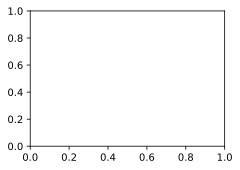

In [1]:
import torch
import torch.nn as nn
import math
import lmy
import numpy as np


def net_accuracy(net, data_iter, loss):
    """评估模型准确率"""
    metric = lmy.Accumulator(2)
    for X, y in data_iter:
        y_hat = net(X)
        y = y.reshape(y_hat.shape)
        l = loss(y_hat, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]


def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='None')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))  # 网络模型为单层的线性网络
    batch_size = min(10, train_labels.shape[0])
    train_iter = lmy.load_array((train_features, train_labels.reshape(-1, 1)), batch_size, True)
    test_iter = lmy.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, False)

    trainer = torch.optim.SGD(net.parameters(), lr=.01)
    animator = lmy.Animator(
        xlabel='epoch',
        ylabel='loss',
        yscale='log',
        xlim=[1, num_epochs + 1],
        ylim=[1e-3, 1e2],
        legend=['train', 'test']
    )

    for epoch in range(num_epochs):
        lmy.train_epoch(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (net_accuracy(net, train_iter, loss),
                                     net_accuracy(net, test_iter, loss)))

    # 输出权重
    print(f"Weights:{net[0].weight.data.numpy()}")


def main():
    max_degree = 20
    n_train, n_test = 100, 100

    # 初始化权重
    true_w = np.zeros(max_degree)
    true_w[:4] = [5, 1.2, -3.4, 5.6]
    lmy.print_shape(true_w, "TrueW")
    # 初始化X
    features = np.random.normal(size=(n_test + n_train, 1))
    np.random.shuffle(features)
    lmy.print_shape(features, "features")

    # 根据公式初始化X,即训练集poly_features
    poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # 逐元素计算次数
    for i in range(max_degree):
        poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)! 逐位除以阶乘
    lmy.print_shape(poly_features, "poly_features")

    labels = np.dot(poly_features, true_w)  # 加权获得真实标签y
    labels += np.random.normal(scale=.1, size=labels.shape)  # 加噪获得最终的y

    # 格式转换
    poly_features = torch.tensor(poly_features)
    labels = torch.tensor(labels)

    lmy.print_shape(labels, 'labels')
    # 开始训练并记录
    train_features, train_labels = poly_features[:n_train, :4], labels[:n_train]
    test_features, test_labels = poly_features[n_train:, :4], labels[n_train:]

    train(train_features, test_features, train_labels, test_labels)


if __name__ == '__main__':
    main()